In [2]:
!pip install -q transformers datasets accelerate torch scikit-learn matplotlib

import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from datasets import Dataset
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
)

In [3]:
import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "disabled"

In [4]:
df = pd.read_csv("all_reviews.csv")
df = df.dropna(subset=["review_text"])
df = df[df["review_text"].str.strip() != ""]

# Convert 1–5 star ratings to labels 0–4
df["label"] = df["rating"] - 1

# Split into training and test sets
train_df, test_df = train_test_split(
    df[["review_text", "label"]],
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

In [5]:
# Tokenize text
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(
        batch["review_text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

train_ds = train_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)
train_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [6]:
# Initialize BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)

# Define training arguments (keeps it compatible with all Colab versions)
training_args = TrainingArguments(
    output_dir="./results_bert_rating",
    do_train=True,
    do_eval=True,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
)

# Set up Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-2780683925.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
#!pip uninstall -y wandb


In [7]:
trainer.train()
trainer.evaluate()


Step,Training Loss
100,1.062800
200,0.699900
300,0.510400


{'eval_loss': 0.6011979579925537,
 'eval_runtime': 1.5223,
 'eval_samples_per_second': 131.378,
 'eval_steps_per_second': 16.422,
 'epoch': 3.0}

Classification Report:
              precision    recall  f1-score   support

           0      0.458     0.688     0.550        16
           1      0.600     0.462     0.522        13
           2      0.333     0.071     0.118        14
           3      0.462     0.273     0.343        22
           4      0.887     0.985     0.933       135

    accuracy                          0.785       200
   macro avg      0.548     0.496     0.493       200
weighted avg      0.748     0.785     0.754       200



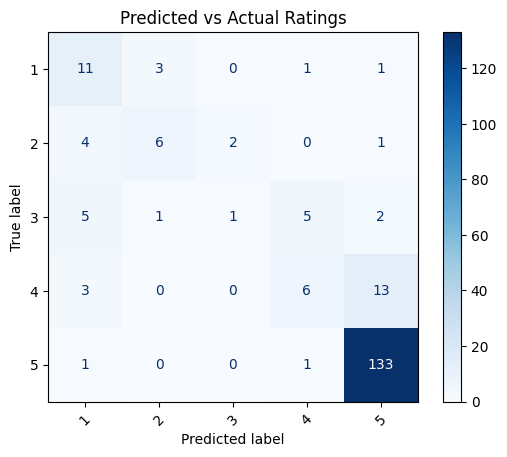

In [8]:
# Evaluate on test data and show metrics
preds = trainer.predict(test_ds)
y_true = test_df["label"]
y_pred = preds.predictions.argmax(-1)

print("Classification Report:")
print(classification_report(y_true, y_pred, digits=3))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4, 5])
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Predicted vs Actual Ratings")
plt.show()